
# Projet: Facebook BaBi tasks
Notebook de la semaine du 08/03
Par Thierry Loesch et Bryce Tichit

Dans ce notebook nous allons commencer par tester le modèle sur différentes tâches et ajuste les paramètres (batch_size,epochs,...) afin de voir comment les résultats varient et ce que nous pouvons faire pour améliorer notre modèle.

Modifier la taille de l'embedding de 50 à 100 -> aucun effet on observe même une regression

# Rappel dernier notebook

Dans le dernier notebook nous avions fait de plus amples tests avec différents modèles, un avec deux réseaux LSTM en symétrique et un autre avec deux réseaux Bi-LSTM en symétrique ainsi qu'un autre modèle plus spécifique. Après vérification il s'avère que les modèls LSTM et Bi-LSTM n'arrivaient pas à généraliser et nous avions des courbes d'apprentissage montrant un sévère sur-apprentissage.


In [65]:
import re

def tokenize(sent):
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]


def parserBabi(data,withoutNoise):
    ret=list()
    story=list() 
    
    for phrase in data:
        phrase = phrase.decode('utf-8').strip()
        id_phrase,phrase = phrase.split(' ',1)
        id_phrase= int(id_phrase)
        
        if id_phrase == 1: #Nouvelle story
            story=list()
            
        if '\t' in phrase: #Si tabulation alors il s'agit de la question ainsi que de la réponse
            q, a, justif = phrase.split('\t')
            q = tokenize(q)
            
            if withoutNoise:
                inds = map(int,justif.split())
                data_story = [story[x-1] for x in inds]
            else:
                data_story = [x for x in story if x] 
                                             
            ret.append((data_story,q,a)) #Nos données d'apprentissages
            story.append('')
        
        else: 
            #Alors la phrase est tout simplement un des élements de raisonnement et non une question
            story.append(tokenize(phrase))
            
    return ret

def readAndParse(f,withoutNoise=False):
    data = parserBabi(f.readlines(),withoutNoise)
    return [([substory for substories in story for substory in substories], q , a) for story,q,a in data]


In [66]:
tokenize("Bonjour?")

['Bonjour', '?']

# Récupération des données

On récupère les fichiers sur internet directement avec la fonction get_file, cette fonction a l'avantage de ne pas tout retelecharger si les données sont déjà sur la machines (dans ~/.keras/datasets). Puis on applique les fonctions du parser afin de récupérer les données dans la structure que l'on veut.

In [16]:
from keras.utils.data_utils import get_file
import tarfile
from random import shuffle
import fnmatch
import os

try:
    path = get_file('babi-tasks-v1-2.tar.gz', origin='http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz')
except:
   print("erreur pendant le telechargement")

def trunc(f):
    s = '{}'.format(f)
    i, p, d = s.partition('.')
    return int('.'.join([i, d][:1]))

def splitData(data,split_take):
    
    size=len(data)
    
    train_prop,test_prop,val_prop = trunc(split_take[0] * size),trunc(split_take[1] * size), trunc(split_take[2] * size)
    
    return data[0:train_prop],data[train_prop:train_prop+test_prop],data[train_prop+test_prop:train_prop+test_prop+val_prop]
   
equalProp = lambda size_data,num : tuple([num/float(size_data)] * 3)

def getChallenge(tar,num,_10k=False):
    
    if(_10k):
        srcdir = 'tasks_1-20_v1-2/en-10k/'
    else:
        srcdir = 'tasks_1-20_v1-2/en/'
        
    for member in tar.getnames():
        
        if fnmatch.fnmatch(member, srcdir+'*') and fnmatch.fnmatch(member,'*qa'+str(num)+'_*'):
            
            #return member
            return '_'.join(member.split('_')[0:-1]) + '_{}.txt'
    

tar = tarfile.open(path)

#challenge = 'tasks_1-20_v1-2/en-10k/qa14_time-reasoning_{}.txt'
#challenge = 'tasks_1-20_v1-2/en/qa19_path-finding_{}.txt'
challenge = getChallenge(tar,10,_10k=True)
withoutNoise=False

print "doing train"
train = readAndParse(tar.extractfile(challenge.format('train')),withoutNoise=withoutNoise)
print "doing test"
test = readAndParse(tar.extractfile(challenge.format('test')),withoutNoise=withoutNoise)
data = train+test

print "Nombre d'exemples total: {}".format(len(data))

#proportions=(0.1,0.1,0.1) 
proportions=equalProp(len(data),1000) #on en veut 1000 pour chaque ensemble
train,test,validation=splitData(data,proportions)

vocab = sorted(reduce(lambda x, y: x | y, (set(story + q + [answer]) for story, q, answer in train + test + validation)))
vocab_size = len(vocab) + 1
word_idx = dict(((w,i+1) for i,w in enumerate(vocab)))

story_max = max((len(x) for x,_,_ in train+test+validation))
question_max = max((len(x) for _,x,_ in train+test+validation))

print "Training: {} samples , Test: {} samples , Validation: {} samples".format(len(train),len(test),len(validation))


doing train
doing test
Nombre d'exemples total: 11000
Training: 1000 samples , Test: 1000 samples , Validation: 1000 samples


# Vectorisation

Comme vu en cours on doit vectoriser nos données (les assimiler a des nombres et les mettre dans des matrices) afin de pouvoir entrainer notre réseau neuronal.

La fonction pad_sequences plus bas permet de transformer notre liste de liste en matrice numpy en ajoutant des 0. pour complèter quand il n'y a pas de données.

In [17]:
#Mettons tout ça dans des matrices
from keras.preprocessing.sequence import pad_sequences
import numpy as np

def vectorize(data,wordidx,storymaxlen,questionmaxlen):
    X,Xq,Y = list(),list(),list()
    
    lookup = lambda m : wordidx[m]
    
    for story, question, reponse in data:
        X.append(map(lookup,story))
        Xq.append(map(lookup,question))
        Yline = np.zeros(vocab_size)
        Yline[wordidx[reponse]] = 1
        Y.append(Yline)
        
    return pad_sequences(X, maxlen=story_max), pad_sequences(Xq, maxlen=question_max), np.array(Y)
        
    
X,Xq,Y = vectorize(train,word_idx,story_max,question_max)
X_test,Xq_test,Y_test = vectorize(test,word_idx,story_max,question_max)
X_val,Xq_val,Y_val = vectorize(validation,word_idx,story_max,question_max)

In [18]:
print X[0:10]
print Xq[0:10]
print Y[0:10]

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   4 13 11 12 23 22 20 23 21  1  7 26  8 24 23 19  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  4 13 11 12 23 22 20 23 21  1  7 26  8 24 23 19
   1  3 13 11 12 23 15 20 23 21  1  4 17 24 23 10  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4 13 11 12
  23 22 20 23 21  1  7 26  8 24 23 19  1  3 13 11 12 23 15 20 23 21  1  4
  17 24 23 10  1  4 13 12 23 19  1  3 17 24 23 10  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  4 13 11 12 23 22 20 23 21  1  7 26  8 24 23 19  1  3 13 11
  12 23 15 20 23 21  1  

# Modèle

Ensuite nous crééons notre modèle keras, nous avions choisi donc de faire un modèle pour les story et pour les questions afin de pouvoir raisonner sur chacun d'eux différement puis de les combiner en un modèle, ainsi nous avons un seul modèle mais qui traite différement les story des questions. On a un LSTM dans le modèle des questions car il faut raisonner d'abord sur les questions seules puis les histoires avec les questions (raisonner sur les histoires seules ne veut pas dire grand chose du point de vue d'un raisonnement)

Schema modèle:

                    question_model                              story_model
                         |                                           |
                      Embedding                                  Embedding
                          |                                          |
                                                                    /
                        LSTM                                       /
                          |                                       /
                        RepeatVector                            /
                                    \                          /
                                      \_______________________/
                                                   |
                                                   |
                                              Merge(mode=concat)
                                                   |
                                                 LSTM
                                                   |
                                                 SoftMax



In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotLearningCurves_acc(history_model,save=''):
    plt.plot(history_model.history['acc'])
    plt.plot(history_model.history['val_acc'])
    plt.title('Precision du modele')
    plt.ylabel('Precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    if save:
        plt.savefig(save,bbox_inches='tight')
    plt.show()
    
def plotLearningCurves_loss(history_model,save=''):
    plt.plot(history_model.history['loss'])
    plt.plot(history_model.history['val_loss'])
    plt.title('Perte sur le modele')
    plt.ylabel('Perte')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    if save:
        plt.savefig(save,bbox_inches='tight')
    plt.show()

In [20]:
-


Train on 1000 samples, validate on 1000 samples
Epoch 1/25
1000/1000 [==============================] - 13s - loss: 1.7120 - acc: 0.4060 - val_loss: 1.0394 - val_acc: 0.4450
Epoch 2/25
1000/1000 [==============================] - 12s - loss: 1.0019 - acc: 0.4520 - val_loss: 1.0256 - val_acc: 0.4450
Epoch 3/25
1000/1000 [==============================] - 13s - loss: 1.0068 - acc: 0.4500 - val_loss: 1.0191 - val_acc: 0.4450
Epoch 4/25
1000/1000 [==============================] - 13s - loss: 0.9927 - acc: 0.4360 - val_loss: 1.0306 - val_acc: 0.4020
Epoch 5/25
1000/1000 [==============================] - 13s - loss: 0.9832 - acc: 0.4530 - val_loss: 1.0357 - val_acc: 0.4450
Epoch 6/25
1000/1000 [==============================] - 13s - loss: 1.0065 - acc: 0.4420 - val_loss: 1.0150 - val_acc: 0.4450
Epoch 7/25
1000/1000 [==============================] - 13s - loss: 0.9974 - acc: 0.4420 - val_loss: 1.0204 - val_acc: 0.4020
Epoch 8/25
1000/1000 [==============================] - 12s - loss: 0.

1000/1000 [==============================] - 2s     

Perte = 1.019
Précision = 47%


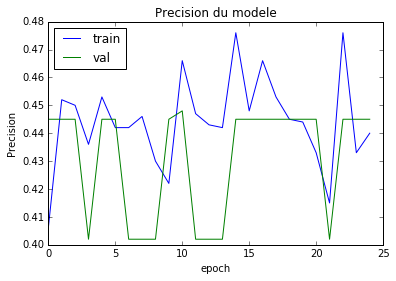

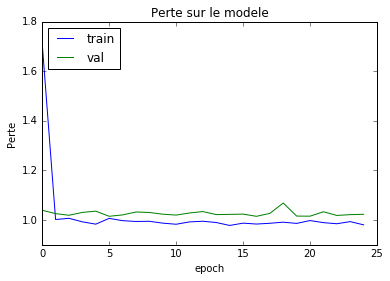

In [21]:
#Calcul de précision sur l'ensemble de test

loss,acc = model.evaluate([X_test,Xq_test],Y_test, batch_size=batch_size)
print "\nPerte = {:.3f}".format(loss)
print "Précision = {:.0f}%".format(acc*100)

plotLearningCurves_acc(history)

plotLearningCurves_loss(history)

In [51]:
#finir ce bout de code

import itertools

def generate_randInt(maxV,n):
    rand = (np.random.randint(0,maxV) for _ in iter(int,1))
    
    return list(itertools.islice(rand,n))

nbSamples = 5
test_samples = [(i,j) for i,j in zip(generate_randInt(len(train),nbSamples),generate_randInt(len(test),nbSamples))]
    
print test_samples

[(987, 134), (191, 262), (909, 556), (664, 685), (164, 262)]


In [63]:
storyget = lambda (s,_,_d) : s 

print storyget(test[0])

print X[0]

print map(lambda w : word_idx[w],storyget(test[0]))

[u'Fred', u'travelled', u'to', u'the', u'office', u'.', u'Bill', u'moved', u'to', u'the', u'kitchen', u'.']
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4 13 11
 12 23 22 20 23 21  1  7 26  8 24 23 19  1]
[4, 25, 24, 23, 19, 1, 3, 17, 24, 23, 15, 1]
